In [1]:
import sys
sys.path.append('fashion-mnist')

from utils.mnist_reader import load_mnist

X_train, y_train = load_mnist('fashion-mnist/data/fashion', kind='train')
X_test, y_test = load_mnist('fashion-mnist/data/fashion', kind='t10k')

In [2]:
import numpy as np
import seaborn as sns
from numba import njit
from random import shuffle
from typing import Dict, List, Tuple, Iterable
from tqdm.notebook import tqdm

In [3]:
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

val_size = int(len(X_train)*0.1)

idx = np.arange(len(X_train))
shuffle(idx)
X_train, y_train = X_train[idx], y_train[idx]
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(54000, 28, 28, 1) (54000,)
(6000, 28, 28, 1) (6000,)
(10000, 28, 28, 1) (10000,)


<Axes: >

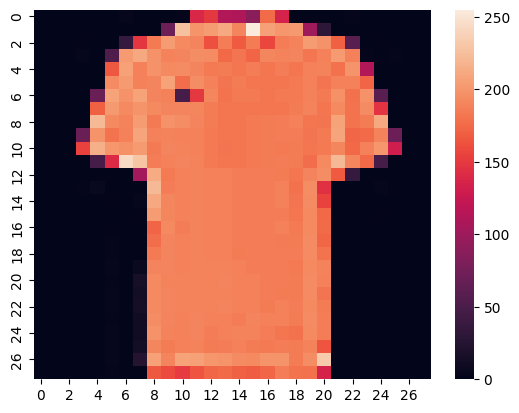

In [4]:
sns.heatmap(X_train[np.random.randint(len(X_train))].reshape((28, 28)))

In [5]:
def data_loader(data: Tuple, batch_size: int, train: bool=False):
    if train:
        idx = np.arange(len(X_train))
        shuffle(idx)
        data = [x[idx] for x in data]
        
    for i in range(0, len(data[0]), batch_size):
        yield tuple(x[i:i+batch_size] for x in data)
        
def prepare_inputs(X: np.ndarray):
    return (X / 255) - 0.5

In [6]:
class Parameter:
    def __init__(self, data: np.ndarray):
        self.data = data
        self.grad = None
        
    def __repr__(self):
        return f"Parameter(data={self.data}, grad={self.grad})"

class Module:
    def __init__(self, lazy: bool=False, **parameters: Dict[str, Parameter]):
        self._parameters: Dict[str, Parameter] = parameters
        self.training = False
        self._is_init = not lazy
        
    def _init(self, *input_shapes: List[Tuple[int]]):
        modules = {}
        for k in dir(self):
            if k == "parameters":
                continue

            v = getattr(self, k)
            if isinstance(v, Module):
                modules[k] = v
            elif isinstance(v, Parameter):
                self._parameters[k] = v
        
        for name, module in modules.items():
            self._parameters.update({f"{name}.{k}": v for k,v in module.parameters.items()})
        
        self._is_init = True
        
    @property
    def parameters(self):
        assert self._is_init, f"{self.__class__.__name__} not initialized!"
        return self._parameters
    
    def __call__(self, *inputs):
        if not self._is_init:
            self._init(*[t.shape for t in inputs])

        self._inputs = inputs
        self._outputs = self.forward(*inputs)
        return self._outputs
    
    def train(self, training: bool=True):
        self.training = training
        for k in dir(self):
            if isinstance(getattr(self, k), Module):
                getattr(self, k).train(training)
        
    def eval(self):
        self.train(False)
        
    def __repr__(self):
        modules = []
        for k in dir(self):
            if k == "parameters":
                continue

            if isinstance(getattr(self, k), Module):
                modules.append(f"{getattr(self, k)}")
                
        return f"{self.__class__.__name__}(\n" + "\n".join(["\t"+module for module in ",\n".join(modules).split("\n")]) + "\n)"
    
        
class ModuleList(Module):
    def __init__(self, modules: List[Module]=[]):
        super().__init__()
        self.modules = modules
        
    def _init(self, *_):
        for i, module in enumerate(self.modules):
            self._parameters.update({f"{i}.{k}": v for k,v in module.parameters.items()})
        super()._init()

    def train(self, training: bool=True):
        for module in self.modules:
            module.train()
        super().train(training)
            
    def __len__(self) -> int:
        return len(self.modules)
            
    def __getitem__(self, idx: int) -> Module:
        return self.modules[idx]
            
    def __iter__(self) -> Iterable[Module]:
        for module in self.modules:
            yield module
            
    def __repr__(self):
        modules = ",\n".join([repr(module) for module in self.modules])
        return "ModuleList([\n" + "\n".join(["\t"+module for module in modules.split("\n")]) + "\n])"

In [7]:
class Linear(Module):
    def __init__(self, output_features: int, input_features: int=None):
        self.output_features = output_features
        self.input_features = input_features
        if self.input_features is not None:
            super().__init__(lazy=False)
            self._init((input_features,))
        else:
            super().__init__(lazy=True)
        
    def _init(self, *input_shapes: Tuple[int]):
        self.input_features = input_shapes[0][-1]
        self.w = Parameter(np.random.randn(self.input_features, self.output_features) * np.sqrt(2 / self.input_features))
        self.b = Parameter(np.zeros(self.output_features))
        super()._init(*input_shapes)
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        return X @ self.w.data + self.b.data
    
    def backward(self, grad_output: np.ndarray):
        assert (grad_output.shape == self._outputs.shape), f"grad_output={grad_output.shape}, output={self._outputs.shape}, input={self._inputs[0].shape}"
        
        X = self._inputs[0].reshape(-1, self._inputs[0].shape[-1])
        grad_output_reshape = grad_output.reshape(-1, grad_output.shape[-1])
        self.w.grad = (X.T) @ grad_output_reshape
        self.b.grad = grad_output_reshape.sum(axis=0)
        return grad_output @ self.w.data.T
    
    def __repr__(self):
        if self._is_init:
            return f"Linear({self.w.data.shape[0]},{self.w.data.shape[1]})"
        return f"Linear(UNKNOWN)"
    
class ReLU(Module):
    def forward(self, X: np.ndarray) -> np.ndarray:
        self._mask = X > 0
        return X * self._mask
    
    def backward(self, grad_output: np.ndarray):
        return grad_output * self._mask
    
    def __repr__(self):
        return f"ReLU()"
    
class Dropout(Module):
    def __init__(self, dropout: float):
        assert (0 <= dropout < 1)
        super().__init__()
        self.dropout = dropout
        
    def forward(self, X: np.ndarray) -> np.ndarray:        
        if self.training:
            self._mask = np.random.rand(*X.shape) > self.dropout
            return (X * self._mask) / (1 - self.dropout)
        
        return X
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        return (grad_output * self._mask) / (1 - self.dropout)
    
    def __repr__(self):
        return f"Dropout({self.dropout})"
    
class ResBlock(Module):
    def __init__(self, hidden_size: int, dropout: float=0.0):
        self.linear = Linear(hidden_size, hidden_size)
        self.relu = ReLU()
        self.dropout = Dropout(dropout)
        super().__init__(**self.linear.parameters)
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        return self.dropout(self.relu(self.linear(X)) + X)
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        assert (grad_output.shape == self._outputs.shape), f"grad_output={grad_output.shape}, output={self._outputs.shape}, input={self._inputs[0].shape}"

        return self.linear.backward(self.relu.backward(self.dropout.backward(grad_output))) + grad_output

In [8]:
class Im2Col(Module):
    def __init__(self, kernel_size: Tuple[int], stride: Tuple[int]):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    @njit
    def _forward(X: np.ndarray, cols: np.ndarray, stride: Tuple[int]) -> np.ndarray:
        Ho, Wo, kh, kw = cols.shape[1:-1]
        sh, sw = stride
        
        for i in range(0, Ho):
            for j in range(0, Wo):
                cols[:, i, j] = X[:, i*sh:i*sh+kh, j*sw:j*sw+kw]
                
    @njit
    def _backward(grad_output: np.ndarray, output: np.ndarray, stride: Tuple[int]) -> np.ndarray:
        Ho, Wo, kh, kw = grad_output.shape[1:-1]
        sh, sw = stride

        for i in range(0, Ho):
            for j in range(0, Wo):
                output[:, i*sh:i*sh+kh, j*sw:j*sw+kw] += grad_output[:, i, j]
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        kh, kw = self.kernel_size
        sh, sw = self.stride
        B, H, W, C = X.shape
        Ho = (H - kh) // sh + 1
        Wo = (W - kw) // sw + 1
        
        cols = np.empty((B, Ho, Wo, kh, kw, C))
        Im2Col._forward(X, cols, self.stride)
        return cols.reshape((*cols.shape[:3], -1))
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        assert (grad_output.shape == self._outputs.shape), f"grad_output={grad_output.shape}, output={self._outputs.shape}, input={self._inputs[0].shape}"

        output = np.zeros_like(self._inputs[0])
        kh, kw = self.kernel_size
        sh, sw = self.stride
        B, H, W, C = output.shape
        Ho = (H - kh) // sh + 1
        Wo = (W - kw) // sw + 1
        
        grad_output = grad_output.reshape(B, Ho, Wo, kh, kw, C)
        Im2Col._backward(grad_output, output, self.stride)
        return output
        

class Conv2D(Module):
    def __init__(self, output_channels: int, kernel_size: Tuple[int], stride: Tuple[int], input_channels: int=None):
        self.output_channels = output_channels
        self.input_channels = input_channels
        if self.input_channels is not None:
            super().__init__(lazy=False)
            self._init((input_channels,))
        else:
            super().__init__(lazy=True)

        self.kernel_size = kernel_size
        self.stride = stride
        
    def _init(self, *input_shapes: List[Tuple[int]]):
        self.im2col = Im2Col(self.kernel_size, self.stride)
        kh, kw = self.kernel_size
        self.input_channels = input_shapes[0][-1]
        self.linear = Linear(self.output_channels, kh * kw * self.input_channels)
        return super()._init(*input_shapes)
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        X = self.im2col(X)
        return self.linear(X)
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        assert (grad_output.shape == self._outputs.shape), f"grad_output={grad_output.shape}, output={self._outputs.shape}, input={self._inputs[0].shape}"
        return self.im2col.backward(self.linear.backward(grad_output))
    
    def __repr__(self):
        if self._is_init:
            return f"Conv2D(\n\tkernel_size={self.kernel_size},\n\tstride={self.stride},\n\tinput_channels={self.input_channels},\n\toutput_channels={self.output_channels})"
        return f"Conv2D(UNKNOWN)"
    

class Flatten(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        self._input_shape = X.shape
        return X.reshape((X.shape[0], -1))
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        return grad_output.reshape(self._input_shape)
    
    def __repr__(self):
        return f"Flatten()"

In [9]:
class Model(Module):
    def __init__(self, input_shape: int, num_classes: int):
        super().__init__(lazy=True)
        H, W, C = input_shape
        
        self.layers = ModuleList([
            Conv2D(16, (3, 3), (1, 1)), ReLU(),
            Conv2D(16, (5, 5), (2, 2)), ReLU(),
            Conv2D(16, (7, 7), (3, 3)), ReLU(),
            Flatten(),
            Linear(num_classes),
        ])
        
        X = np.random.rand(1, H, W, C)
        _ = self.forward(X)
        self._init()
        
    def _init(self, *_):
        self.layers._init()
        return super()._init()
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            X = layer(X)
        return X
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        
        return grad_output

In [10]:
def softmax(z: np.ndarray) -> np.ndarray:
    ez = np.exp(z - z.max(axis=-1, keepdims=True))
    return ez / ez.sum(axis=-1, keepdims=True)

def accuracy(preds: np.ndarray, targets: np.ndarray) -> float:
    return (preds == targets).mean().item()

In [11]:
class Loss(Module):
    def forward(self, logits: np.ndarray, y: np.ndarray) -> np.ndarray:
        logits -= logits.max(axis=-1, keepdims=True)
        return (np.log(np.sum(np.exp(logits), axis=-1)) - logits[np.arange(len(y)), y]).mean()
    
    def backward(self, _) -> np.ndarray:
        logits, y = self._inputs
        grads = softmax(logits)
        grads[np.arange(len(y)), y] -= 1
        return grads / len(y)

In [12]:
class SGD:
    def __init__(self, params: Dict[str, Parameter], lr: float, weight_decay: float=0.0, max_grad_norm: float=1.0):
        self.params = params
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_grad_norm = max_grad_norm
        
    def step(self):
        for name, param in self.params.items():
            assert param.data.shape == param.grad.shape, f"{name}: param={param.data.shape}, grad={param.grad.shape}"
            param.grad *= self.max_grad_norm / max(self.max_grad_norm, (param.grad ** 2).sum())
            param.data -= self.lr * (param.grad + self.weight_decay * param.data)
            
    def zero_grad(self):
        for param in self.params.values():
            param.grad = None

In [13]:
batch_size = 128
lr = 0.05
weight_decay = 0.0
num_epochs = 10

model = Model((28, 28, 1), 10)
loss_fn = Loss()
optim = SGD(model.parameters, lr=lr, weight_decay=weight_decay)

In [14]:
def train_epoch(pbar):
    pbar.total = len(X_train)
    train_loss = 0
    num_train_samples = 0
    model.train()
    for X, y in data_loader((X_train, y_train), batch_size, True):
        loss = loss_fn(model(prepare_inputs(X)), y)

        optim.zero_grad()
        model.backward(loss_fn.backward(None))
        optim.step()

        train_loss += (loss * len(X)).item()
        num_train_samples += len(X)
        pbar.update(len(X))
        pbar.set_postfix({"train_loss": train_loss / num_train_samples})
        
    return train_loss / num_train_samples
        

def evaluate(pbar, data):
    X_val, y_val = data
    pbar.total = len(X_val)
    val_loss = 0
    num_val_samples = 0
    preds = []
    model.eval()
    for X, y in data_loader((X_val, y_val), batch_size, False):
        outputs = model(prepare_inputs(X))
        loss = loss_fn(outputs, y)
        preds += outputs.argmax(axis=-1).tolist()

        val_loss += (loss * len(X)).item()
        num_val_samples += len(X)
        pbar.update(len(X))
        pbar.set_postfix({"val_loss": val_loss / num_val_samples, "accuracy": accuracy(np.asarray(preds), y_val[:num_val_samples])})
        
    return val_loss / num_val_samples, accuracy(np.asarray(preds), y_val[:num_val_samples])

In [15]:
with tqdm() as pbar:
    pbar.set_description("Val")
    val_loss, val_accuracy = evaluate(pbar, (X_val, y_val))
    print(f"Initial: {val_loss=}, {val_accuracy}")
    
    for epoch in range(num_epochs):
        pbar.reset()
        pbar.set_description("Train")
        train_loss = train_epoch(pbar)

        pbar.reset()
        pbar.set_description("Val")
        val_loss, val_accuracy = evaluate(pbar, (X_val, y_val))
        
        print(f"Epoch {epoch}: {train_loss=}, {val_loss=}, {val_accuracy=}")

    pbar.set_description("Test")
    test_loss, test_accuracy = evaluate(pbar, (X_test, y_test))
    
print(f"Test accuracy: {test_loss=}, {test_accuracy}")

0it [00:00, ?it/s]

Initial: val_loss=2.348135272145917, 0.11666666666666667
Epoch 0: train_loss=0.7582534255080419, val_loss=0.5931811768288147, val_accuracy=0.786
Epoch 1: train_loss=0.5394443036552121, val_loss=0.5053486906925858, val_accuracy=0.8196666666666667
Epoch 2: train_loss=0.48119859965116396, val_loss=0.45663642466106846, val_accuracy=0.8385
Epoch 3: train_loss=0.4393717763842523, val_loss=0.4310332297955454, val_accuracy=0.8433333333333334
Epoch 4: train_loss=0.41029708461829184, val_loss=0.4025190237832872, val_accuracy=0.8551666666666666
Epoch 5: train_loss=0.3892266218682508, val_loss=0.38078063680534663, val_accuracy=0.8621666666666666
Epoch 6: train_loss=0.3692636188607124, val_loss=0.3683948485433998, val_accuracy=0.867
Epoch 7: train_loss=0.3535428773903829, val_loss=0.35110731142903207, val_accuracy=0.869
Epoch 8: train_loss=0.34066508574561183, val_loss=0.34430290952983267, val_accuracy=0.8721666666666666
Epoch 9: train_loss=0.3288217616820675, val_loss=0.3289731341025195, val_accur